# Penyeimbangan Dataset Ecoli

## **1. Dataset Ecoli Dari UCI Disimpan Ke Database Mysql**

1. Download dataset ecoli dari UCI https://archive.ics.uci.edu/dataset/39/ecoli
2. Simpan didatabase MySQL
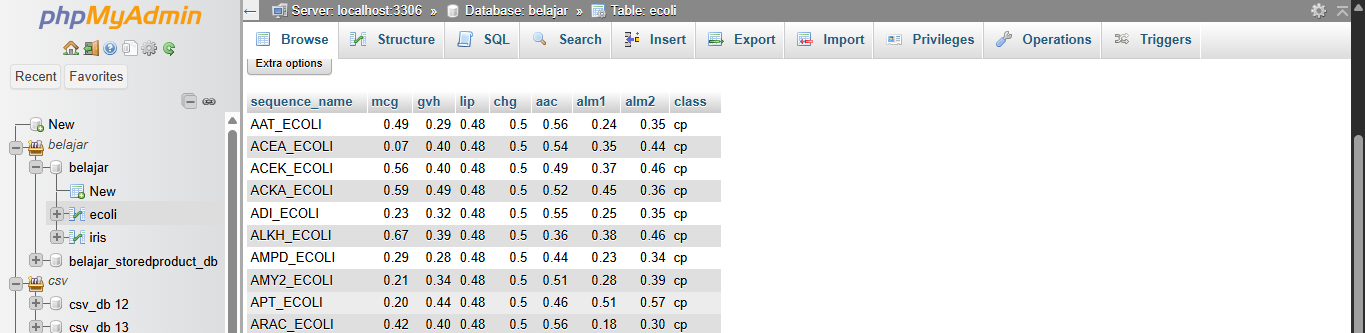

In [ ]:
%pip install pymysql
%pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.8 MB/s eta 0:00:00


### baca file

In [ ]:
df = pd.read_csv("ecoli.csv")


### import libary yang diperlukan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pymysql
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter

### **Visualisasi Distribusi Kelas**

Distribusi kelas:
cp: 143 samples (42.6%)
im: 77 samples (22.9%)
imL: 2 samples (0.6%)
imS: 2 samples (0.6%)
imU: 35 samples (10.4%)
om: 20 samples (6.0%)
omL: 5 samples (1.5%)
pp: 52 samples (15.5%)


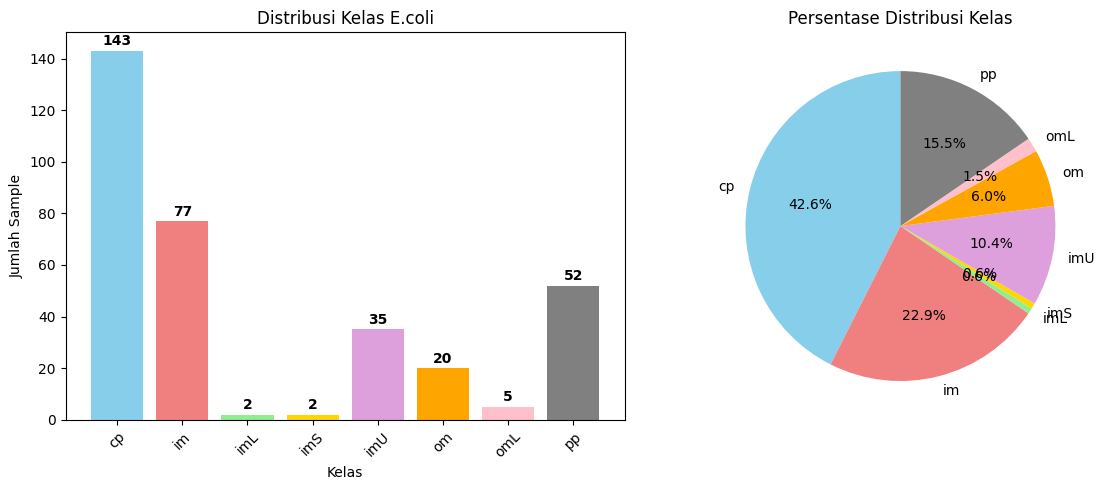


Kelas terbanyak: cp (42.6%)
Kelas tersedikit: imL (0.6%)
Rasio ketidakseimbangan: 71.5:1
Status: TIDAK SEIMBANG


In [ ]:
if df is not None:
    class_counts = df['class'].value_counts().sort_index()

    print("Distribusi kelas:")
    for class_name, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{class_name}: {count} samples ({percentage:.1f}%)")

    plt.figure(figsize=(12, 5))

    # 1. Bar Chart
    plt.subplot(1, 2, 1)
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold',
              'plum', 'orange', 'pink', 'gray']
    bars = plt.bar(class_counts.index, class_counts.values,
                   color=colors[:len(class_counts)])
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sample')
    plt.title('Distribusi Kelas E.coli')
    plt.xticks(rotation=45)

    # Tambah label angka di atas bar
    for bar, count in zip(bars, class_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom', fontweight='bold')

    # 2. Pie Chart
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors[:len(class_counts)], startangle=90)
    plt.title('Persentase Distribusi Kelas')

    plt.tight_layout()
    plt.show()

    # === 5. Status keseimbangan ===
    max_pct = (class_counts.max() / len(df)) * 100
    min_pct = (class_counts.min() / len(df)) * 100
    ratio = max_pct / min_pct

    print(f"\nKelas terbanyak: {class_counts.idxmax()} ({max_pct:.1f}%)")
    print(f"Kelas tersedikit: {class_counts.idxmin()} ({min_pct:.1f}%)")
    print(f"Rasio ketidakseimbangan: {ratio:.1f}:1")

    if ratio > 3:
        print("Status: TIDAK SEIMBANG")
    else:
        print("Status: RELATIF SEIMBANG")

else:
    print("Data tidak tersedia!")

## **2. Tampilkan data dalam scatter plot  menggunakan PCA. (PCA mentransformasi data menjadi dimensi rendah (2))**

Data shape: (336, 9)
Columns: ['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'class']


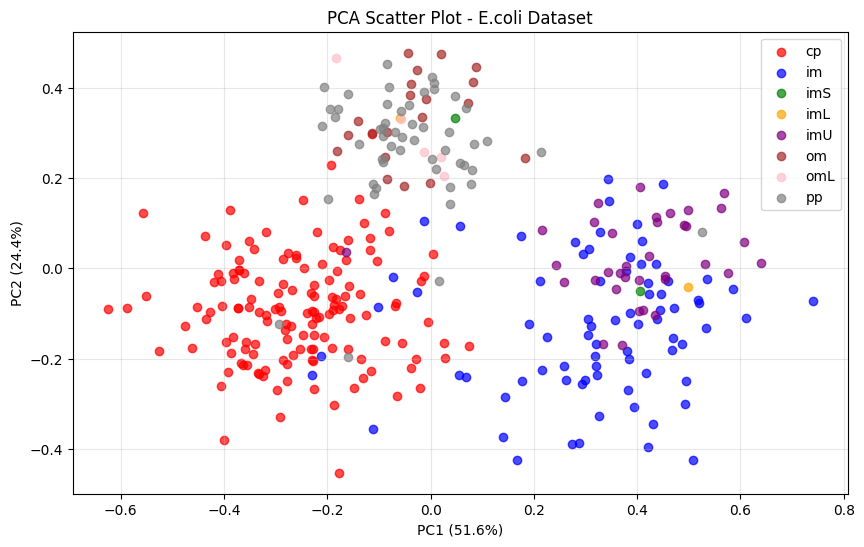

Total variance explained: 76.0%
PCA components shape: (336, 2)

DataFrame PCA (5 baris pertama):
          PC1       PC2 class
0   -0.285601 -0.035274    cp
1   -0.290838 -0.330159    cp
2   -0.104676  0.015248    cp
3   -0.087943  0.122218    cp
4   -0.366268 -0.210366    cp
..        ...       ...   ...
331  0.084233  0.274803    pp
332 -0.139026  0.274116    pp
333 -0.111904  0.187103    pp
334 -0.106204  0.178851    pp
335  0.108764  0.281129    pp

[336 rows x 3 columns]


In [ ]:
if df is not None:
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    feature_columns = ['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']
    X = df[feature_columns]
    y = df['class']

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    dataframe_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    dataframe_pca['class'] = y.values

    # Plot scatter
    plt.figure(figsize=(10, 6))

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    for i, class_name in enumerate(y.unique()):
        mask = y == class_name
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=colors[i], label=class_name, alpha=0.7)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title('PCA Scatter Plot - E.coli Dataset')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")
    print("PCA components shape:", X_pca.shape)
    print("\nDataFrame PCA (5 baris pertama):")
    print(dataframe_pca)

## **3. Penyeimbangan data menggunakan ADASYN dan SMOTE**

### **Penyeimbangan ADASYN**

In [ ]:

print("Distribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y).items())}")

nt = X
ns = y

temp = sorted(class_counts)
print(f"Sorted counts untuk iterasi: {temp}")

for i in range(0, 7):
    n = max(1, temp[i] - 1)

    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")

Distribusi kelas sebelum ADASYN:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 3: menggunakan k_neighbors=4
Hasil iterasi 3: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]

Iterasi 4: menggunakan k_neighbors=19
Hasil iterasi 4: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 5: menggunakan k_neighbors=34
Hasil iterasi 5: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 145), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 

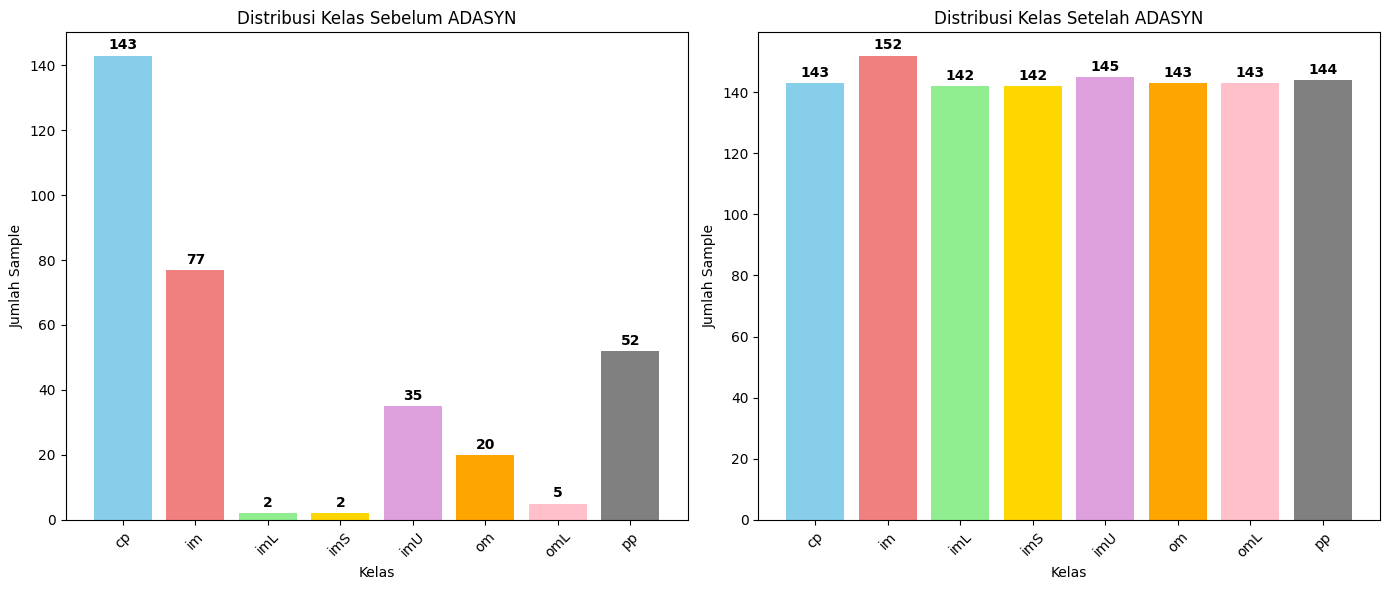


=== SUMMARY ADASYN ===
Peningkatan per kelas:
  cp: 0 samples (143 → 143)
  im: +75 samples (77 → 152)
  imL: +140 samples (2 → 142)
  imS: +140 samples (2 → 142)
  imU: +110 samples (35 → 145)
  om: +123 samples (20 → 143)
  omL: +138 samples (5 → 143)
  pp: +92 samples (52 → 144)


In [ ]:
# Visualisasi perbandingan sebelum dan sesudah ADASYN
plt.figure(figsize=(14, 6))


original_counts = Counter(y)
adasyn_counts = Counter(ns)
classes = sorted(original_counts.keys())

original_values = [original_counts[cls] for cls in classes]
adasyn_values = [adasyn_counts[cls] for cls in classes]

# Plot 1: Sebelum ADASYN
plt.subplot(1, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'pink', 'gray']
bars1 = plt.bar(classes, original_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Sebelum ADASYN')
plt.xticks(rotation=45)

for bar, count in zip(bars1, original_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Setelah ADASYN
plt.subplot(1, 2, 2)
bars2 = plt.bar(classes, adasyn_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Setelah ADASYN')
plt.xticks(rotation=45)

for bar, count in zip(bars2, adasyn_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== SUMMARY ADASYN ===")
print(f"Peningkatan per kelas:")
for cls in classes:
    increase = adasyn_counts[cls] - original_counts[cls]
    if increase > 0:
        print(f"  {cls}: +{increase} samples ({original_counts[cls]} → {adasyn_counts[cls]})")
    else:
        print(f"  {cls}: {increase} samples ({original_counts[cls]} → {adasyn_counts[cls]})")

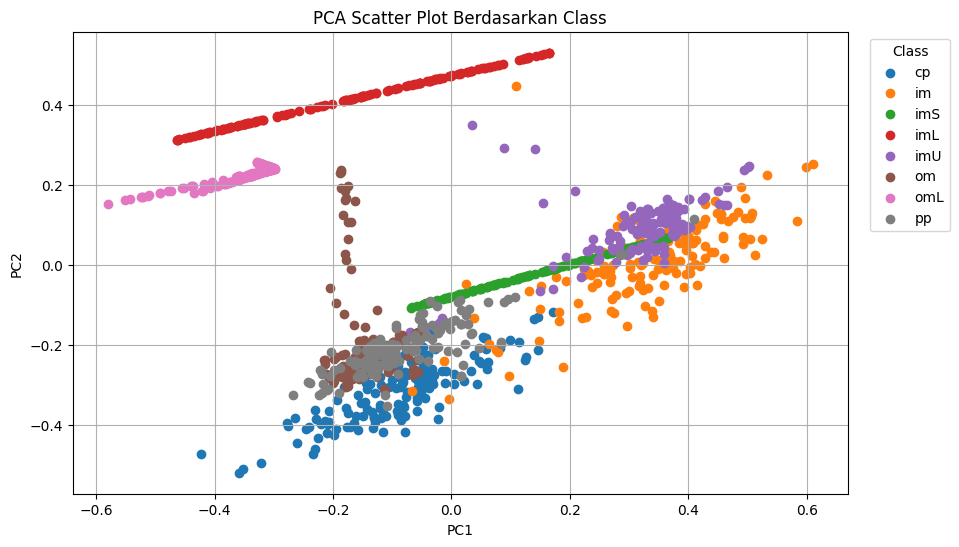

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(nt)

data_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
data_pca['localization_class'] = ns

plt.figure(figsize=(10,6))
for label in data_pca['localization_class'].unique():
    subset = data_pca[data_pca['localization_class'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label)

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.title("PCA Scatter Plot Berdasarkan Class")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid()

plt.show()

### **Penyeimbangan SMOTE**

In [ ]:
print("Distribusi kelas sebelum SMOTE:")
print(f"{sorted(Counter(y).items())}")

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print(f"\nDistribusi kelas setelah SMOTE:")
print(f"{sorted(Counter(y_res).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(y_res)}")
print(f"Data yang ditambahkan: {len(y_res) - len(y)}")

Distribusi kelas sebelum SMOTE:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Distribusi kelas setelah SMOTE:
[('cp', 143), ('im', 143), ('imL', 143), ('imS', 143), ('imU', 143), ('om', 143), ('omL', 143), ('pp', 143)]

Total samples sebelum: 336
Total samples setelah: 1144
Data yang ditambahkan: 808


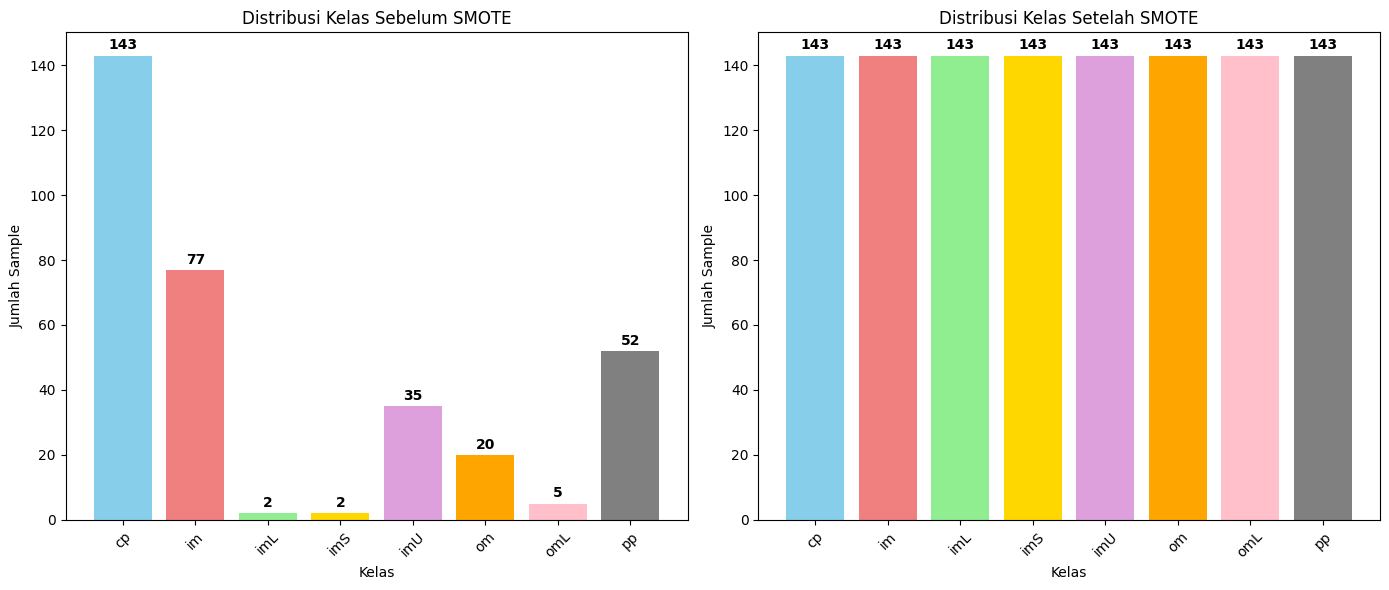


=== SUMMARY SMOTE ===
Peningkatan per kelas:
  cp: 0 samples (143 → 143)
  im: +66 samples (77 → 143)
  imL: +141 samples (2 → 143)
  imS: +141 samples (2 → 143)
  imU: +108 samples (35 → 143)
  om: +123 samples (20 → 143)
  omL: +138 samples (5 → 143)
  pp: +91 samples (52 → 143)


In [ ]:
plt.figure(figsize=(14, 6))

original_counts_smote = Counter(y)
smote_counts = Counter(y_res)
classes = sorted(original_counts_smote.keys())

original_values = [original_counts_smote[cls] for cls in classes]
smote_values = [smote_counts[cls] for cls in classes]

# Plot 1: Sebelum SMOTE
plt.subplot(1, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'pink', 'gray']
bars1 = plt.bar(classes, original_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xticks(rotation=45)

for bar, count in zip(bars1, original_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

# Plot 2: Setelah SMOTE
plt.subplot(1, 2, 2)
bars2 = plt.bar(classes, smote_values, color=colors[:len(classes)])
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.title('Distribusi Kelas Setelah SMOTE')
plt.xticks(rotation=45)

for bar, count in zip(bars2, smote_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print(f"\n=== SUMMARY SMOTE ===")
print(f"Peningkatan per kelas:")
for cls in classes:
    increase = smote_counts[cls] - original_counts_smote[cls]
    if increase > 0:
        print(f"  {cls}: +{increase} samples ({original_counts_smote[cls]} → {smote_counts[cls]})")
    else:
        print(f"  {cls}: {increase} samples ({original_counts_smote[cls]} → {smote_counts[cls]})")

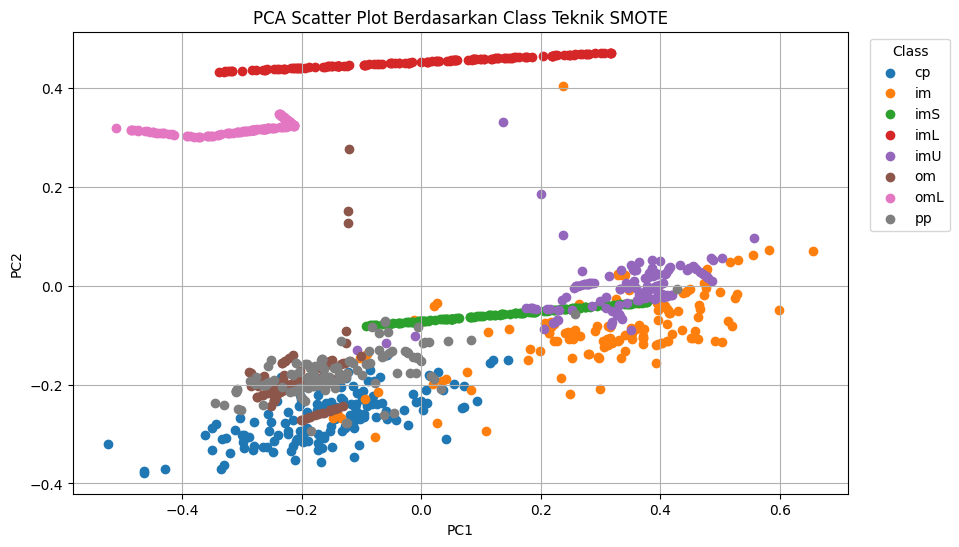

In [ ]:
pcba = PCA(n_components=2)
pca_result = pcba.fit_transform(X_res)
data_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
data_pca['localization_class'] = y_res

plt.figure(figsize=(10,6))
for label in data_pca['localization_class'].unique():
    subset = data_pca[data_pca['localization_class'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot Berdasarkan Class Teknik SMOTE")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid()
plt.show()

### **perbandingan SMOTE DENGAN ADASYN**


=== Perbandingan Distribusi Kelas ===
Kelas  Asli  ADASYN  SMOTE
   cp   143     143    143
   im    77     152    143
  imL     2     142    143
  imS     2     142    143
  imU    35     145    143
   om    20     143    143
  omL     5     143    143
   pp    52     144    143


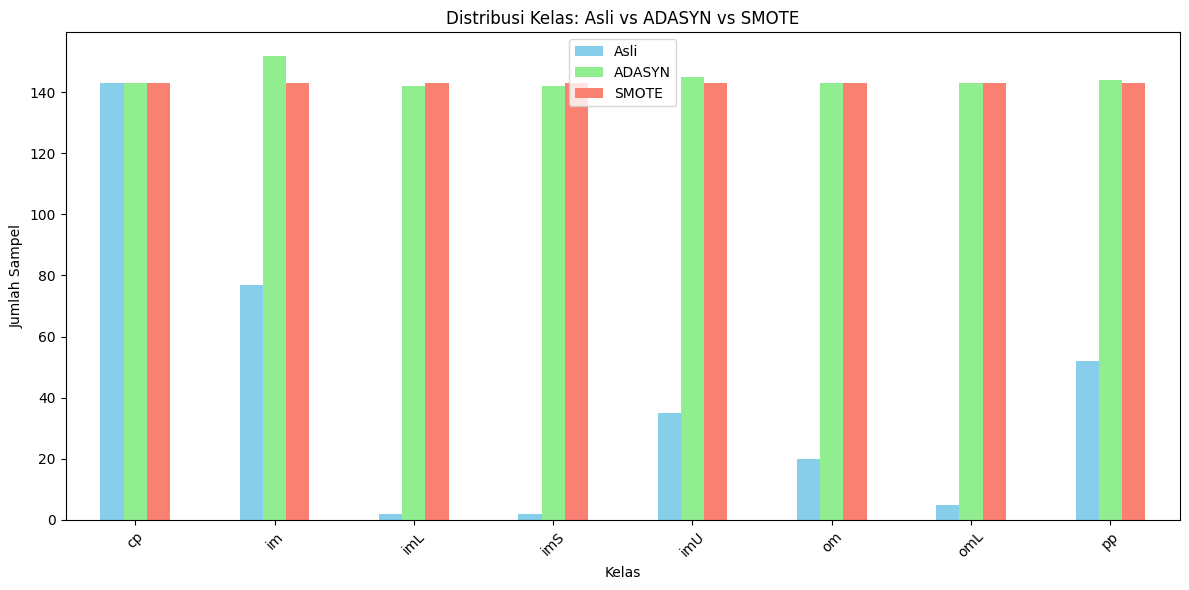

In [ ]:
perbandingan = pd.DataFrame({
    "Kelas": sorted(Counter(y).keys()),
    "Asli": [Counter(y)[k] for k in sorted(Counter(y))],
    "ADASYN": [Counter(ns)[k] for k in sorted(Counter(y))],
    "SMOTE": [Counter(y_res)[k] for k in sorted(Counter(y))]
})

print("\n=== Perbandingan Distribusi Kelas ===")
print(perbandingan.to_string(index=False))

# Plot bar chart perbandingan
perbandingan.set_index("Kelas").plot(
    kind="bar", figsize=(12,6),
    color=["skyblue", "lightgreen", "salmon"]
)
plt.title("Distribusi Kelas: Asli vs ADASYN vs SMOTE")
plt.ylabel("Jumlah Sampel")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **4. Ploting Data Setelah Di Seimbangkan Menggunakan PCA**

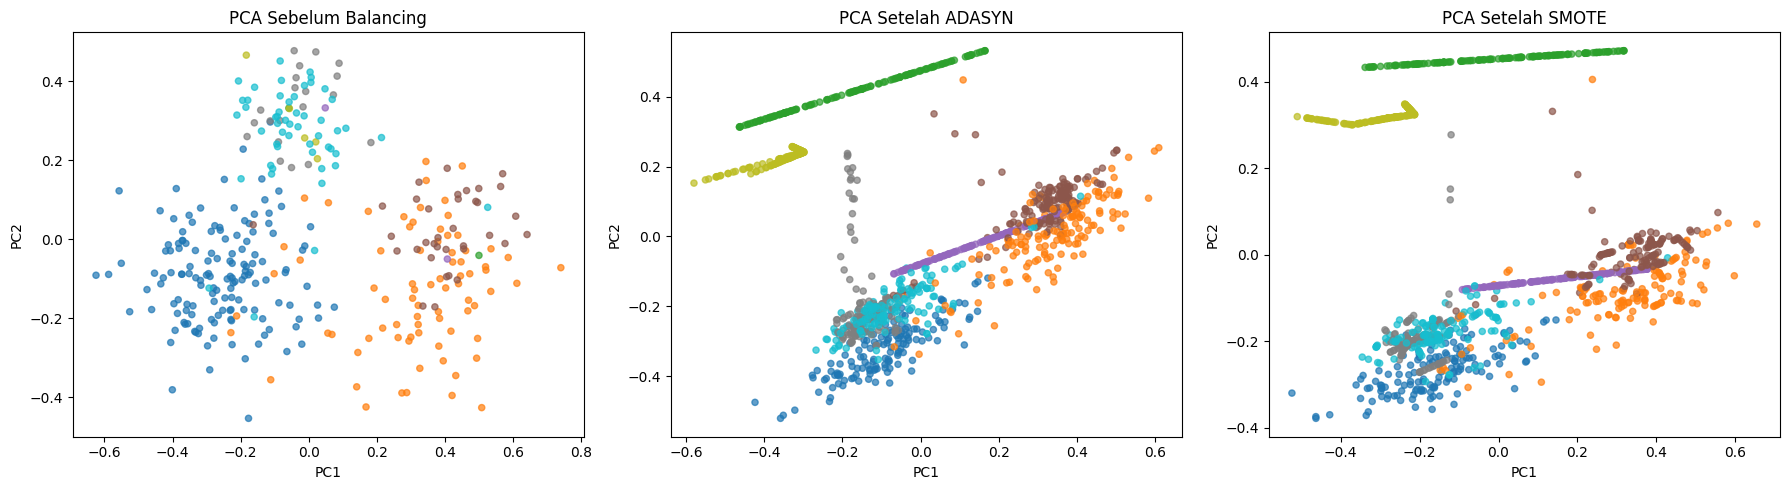

In [ ]:
# Encode label string jadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)
ns_encoded = le.transform(ns)   # ADASYN result
y_res_encoded = le.transform(y_res)  # SMOTE result

# --- PCA ---
pca = PCA(n_components=2)

X_pca_orig = pca.fit_transform(X)
X_pca_adasyn = pca.fit_transform(nt)
X_pca_smote = pca.fit_transform(X_res)

# --- Plot ---
plt.figure(figsize=(18, 5))

# 1. Sebelum balancing
plt.subplot(1, 3, 1)
plt.scatter(X_pca_orig[:, 0], X_pca_orig[:, 1], c=y_encoded, cmap='tab10', s=20, alpha=0.7)
plt.title("PCA Sebelum Balancing")
plt.xlabel("PC1")
plt.ylabel("PC2")

# 2. Setelah ADASYN
plt.subplot(1, 3, 2)
plt.scatter(X_pca_adasyn[:, 0], X_pca_adasyn[:, 1], c=ns_encoded, cmap='tab10', s=20, alpha=0.7)
plt.title("PCA Setelah ADASYN")
plt.xlabel("PC1")
plt.ylabel("PC2")

# 3. Setelah SMOTE
plt.subplot(1, 3, 3)
plt.scatter(X_pca_smote[:, 0], X_pca_smote[:, 1], c=y_res_encoded, cmap='tab10', s=20, alpha=0.7)
plt.title("PCA Setelah SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

1. PCA Sebelum Balancing

    Titik-titik merepresentasikan data asli sebelum dilakukan oversampling.
    
    Terlihat beberapa kelompok besar (cluster), tetapi ada kelas minoritas (contoh di pojok atas atau samping) yang jumlahnya jauh lebih sedikit dibandingkan kelas mayoritas.

    Hal ini menunjukkan ketidakseimbangan kelas — sebagian besar data terkonsentrasi hanya di beberapa kelas, sementara kelas kecil hanya muncul sedikit.

2. PCA Setelah ADASYN

    ADASYN (Adaptive Synthetic Sampling) lebih agresif terhadap kelas minoritas.

    Pada grafik terlihat titik-titik dari kelas minoritas ditambahkan lebih banyak, terutama di area yang jaraknya cukup jauh dari mayoritas.

    Hasilnya distribusi data jadi lebih merata, tapi titik sintetis ADASYN cenderung mengikuti arah pola distribusi (garis memanjang).

    Artinya ADASYN berusaha menyesuaikan penambahan sampel sesuai kesulitan klasifikasi, bukan sekadar menambahkan titik di sekitar data minoritas.

3. PCA Setelah SMOTE

    SMOTE (Synthetic Minority Oversampling Technique) menambahkan sampel baru dengan cara interpolasi antar tetangga terdekat.

    Terlihat data minoritas bertambah, tetapi pola distribusinya lebih rapi dibanding ADASYN.

    Hasilnya, kelas minoritas diperluas dengan titik sintetis yang menyebar lebih teratur di sekitar data asli.

    Namun, SMOTE kadang menghasilkan data yang "kurang realistis" jika kelas sangat sedikit, karena interpolasi dipaksakan antar tetangga.